# County level yield analysis: Figure 3

In [24]:
import pandas as pd
import numpy as np
import geopandas as gp
import scipy.stats as ss
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Avenir'
plt.rcParams['mathtext.rm'] = 'Avenir'
plt.rcParams['mathtext.it'] = 'Avenir:italic'
plt.rcParams['mathtext.bf'] = 'Avenir:bold'
plt.rcParams['font.size'] = 22
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
plt.rcParams['pdf.fonttype'] = 42

cm_data = np.loadtxt("../plotting_tools/batlow.txt")[::-1]
batlow_map = LinearSegmentedColormap.from_list("Batlow", cm_data)

In [19]:
# Import plotting shapefiles
county_shp = gp.read_file('../plotting_tools/counties_contig_plot.shp')
county_shp["GEOID"] = county_shp["GEOID"].astype(str).str.zfill(5)
county_shp['area'] = county_shp['geometry'].apply(lambda x: x.area)
county_shp = county_shp.query('area > 10e3')

# Add State filter for plot
county_shp_plot = county_shp.copy()
county_shp_plot['state'] = county_shp_plot['GEOID'].str[:2]
county_shp_plot.set_index(['state'], inplace=True)
StateDrop = ['53', '41', '16', '06', '04', '49', '56', '30', '08', '35', '32'] # Western half of CONUS
county_shp_plot = county_shp_plot.drop(StateDrop)

states = gp.read_file('../plotting_tools/states_contig_plot.shp')
coast = gp.read_file('../plotting_tools/coast_contig_plot.shp')

In [30]:
# Get both ensembles
from combine import combine_nex_yield, combine_cmip_yield
nex_all = combine_nex_yield()
cmip_all = combine_cmip_yield()

In [5]:
# Set indexing
nex_all.set_index(['GEOID','Year'], inplace=True)
cmip_all.set_index(['GEOID','Year'], inplace=True)

### Fit bandwidths for each county

In [25]:
# Interquartile range
def get_iqr(dat):
    return np.quantile(dat, 0.75) - np.quantile(dat, 0.25)

# Silverman bandwidth estimate
def silverman(dat):
    return 0.9 * np.min([np.std(dat), get_iqr(dat)/1.34]) * len(dat)**-0.2

In [44]:
%%time
#############################
#### WARNING: this took 1hr 20mins to run on my local machine. Importing the results (next cell) will be much faster
############################
NEXres = {}
CMIPres = {}
for geoid in nex_all.index.unique(level = 'GEOID'):
    # Ensembles
    NEXens = nex_all.loc[geoid].drop(columns=['GMFD']).to_numpy().flatten()
    CMIPens = cmip_all.loc[geoid].drop(columns=['GMFD']).to_numpy().flatten()
    # Obs
    GMFDobs = nex_all.loc[geoid].filter(['GMFD']).to_numpy()
    # Find best bandswidth
    nexgrid = GridSearchCV(KernelDensity(), {'bandwidth': np.linspace(0.5*silverman(NEXens), 2*silverman(NEXens), 20)})
    cmipgrid = GridSearchCV(KernelDensity(), {'bandwidth': np.linspace(0.5*silverman(CMIPens), 2*silverman(CMIPens), 20)})
    nexgrid.fit(NEXens[:, None])
    cmipgrid.fit(CMIPens[:, None])
    NEXres.update({geoid : nexgrid.best_params_['bandwidth']})
    CMIPres.update({geoid : cmipgrid.best_params_['bandwidth']})

# Store results
NEX_res = pd.DataFrame.from_dict(NEXres, orient = 'index', columns = ['bw'])
NEX_res.index.name = 'GEOID'
NEX_res.to_csv('./bandwidths/nex_yield_bws.csv')

CMIP_res = pd.DataFrame.from_dict(CMIPres, orient = 'index', columns = ['bw'])
CMIP_res.index.name = 'GEOID'
CMIP_res.to_csv('./bandwidths/cmip_yield_bws.csv')

CPU times: user 1h 20min 27s, sys: 25.7 s, total: 1h 20min 53s
Wall time: 1h 24min 14s


In [89]:
# Import results
NEX_res = pd.read_csv('./bandwidths/nex_yield_bws.csv')
NEX_res['GEOID'] = NEX_res['GEOID'].astype(str).str.zfill(5)
NEX_res.set_index(['GEOID'], inplace=True)
CMIP_res = pd.read_csv('./bandwidths/cmip_yield_bws.csv')
CMIP_res['GEOID'] = CMIP_res['GEOID'].astype(str).str.zfill(5)
CMIP_res.set_index(['GEOID'], inplace=True)

### Calculate tail probabilities for each test statistic, for each county

In [112]:
%%time
#############################
#### WARNING: this took 3hrs 17mins to run on my local machine. Importing the results (next cell) will be much faster
############################
# Results dict
NEXtail = []
CMIPtail = []
# Loop over each county
for geoid in nex_all.index.unique(level='GEOID'):
    # Ensembles
    NEXens = nex_all.loc[geoid].drop(columns=['GMFD']).to_numpy().flatten()
    CMIPens = cmip_all.loc[geoid].drop(columns=['GMFD']).to_numpy().flatten()
    # Obs
    GMFDobs = nex_all.loc[geoid].filter(['GMFD']).to_numpy()
    # KDEs
    nex_kde_skl = KernelDensity(bandwidth=NEX_res.loc[geoid]['bw'])
    cmip_kde_skl = KernelDensity(bandwidth=CMIP_res.loc[geoid]['bw'])
    nex_kde_skl.fit(NEXens[:, None])
    cmip_kde_skl.fit(CMIPens[:, None])
    # Construct sample
    nex_sample = np.array([nex_kde_skl.sample(n_samples=len(GMFDobs)).flatten() for i in range(10000)])
    cmip_sample = np.array([cmip_kde_skl.sample(n_samples=len(GMFDobs)).flatten() for i in range(10000)])

    # SD
    nex_sd_sample = np.array([np.std(dat) for dat in nex_sample])
    cmip_sd_sample = np.array([np.std(dat) for dat in cmip_sample])
    nex_sd_ecdf = ECDF(nex_sd_sample)
    cmip_sd_ecdf = ECDF(cmip_sd_sample)
    gmfd_sd = np.std(GMFDobs)

    # MAD
    nex_mad_sample = np.array([ss.median_absolute_deviation(dat) for dat in nex_sample])
    cmip_mad_sample = np.array([ss.median_absolute_deviation(dat) for dat in cmip_sample])
    nex_mad_ecdf = ECDF(nex_mad_sample)
    cmip_mad_ecdf = ECDF(cmip_mad_sample)
    gmfd_mad = ss.median_absolute_deviation(GMFDobs)
    
    # Min
    nex_min_sample = np.array([dat.min() for dat in nex_sample])
    cmip_min_sample = np.array([dat.min() for dat in cmip_sample])
    nex_min_ecdf = ECDF(nex_min_sample)
    cmip_min_ecdf = ECDF(cmip_min_sample)
    gmfd_min = GMFDobs.min()
    
    # Store
    NEXtail.append({'GEOID': geoid,
                    'gmfd_sd': 1.-nex_sd_ecdf(gmfd_sd),
                    'gmfd_mad': 1.-nex_mad_ecdf(gmfd_mad)[0],
                    'gmfd_min': 1.-nex_min_ecdf(gmfd_min)
                   })
    CMIPtail.append({'GEOID': geoid,
                     'gmfd_sd': 1.-cmip_sd_ecdf(gmfd_sd),
                     'gmfd_mad': 1.-cmip_mad_ecdf(gmfd_mad)[0],
                     'gmfd_min': 1.-cmip_min_ecdf(gmfd_min)
                    })
    
# Store results
NEX_tail = pd.DataFrame.from_dict(NEXtail)
NEX_tail.to_csv('./output/nex_yield_pvals_60-05.csv', index=False)

CMIP_tail = pd.DataFrame.from_dict(CMIPtail)
CMIP_tail.to_csv('./output/cmip_yield_pvals_60-05.csv', index=False)

CPU times: user 3h 17min 21s, sys: 29.7 s, total: 3h 17min 51s
Wall time: 3h 18min 32s


In [6]:
# Read results
NEX_tail = pd.read_csv('./output/nex_yield_pvals_60-05.csv')
NEX_tail['GEOID'] = NEX_tail['GEOID'].astype(str).str.zfill(5)
CMIP_tail = pd.read_csv('./output/cmip_yield_pvals_60-05.csv')
CMIP_tail['GEOID'] = CMIP_tail['GEOID'].astype(str).str.zfill(5)

## Figure 3

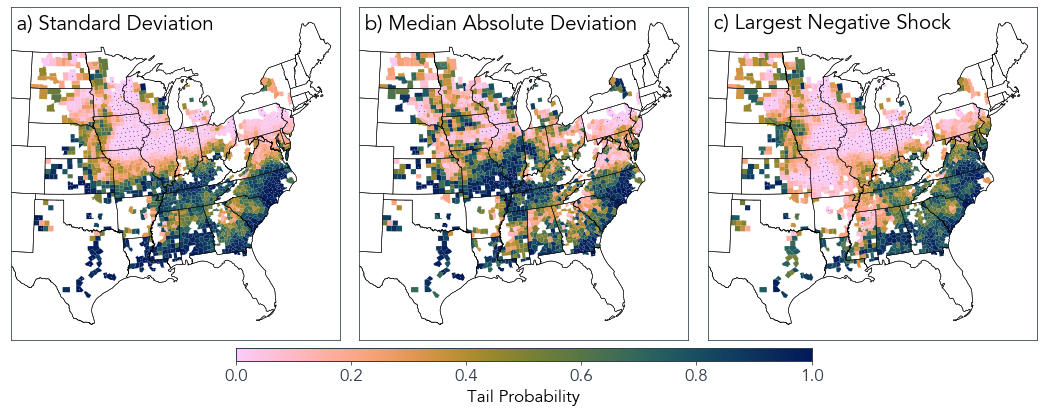

In [27]:
##################################################################################################
####### Comment this out to plot all counties (otherwise only counties with F-test p-value < 0.05)
p05_counties = pd.read_csv('../ag_model/fit_model/ag_model_coeff_final.csv').query('pval < 0.05')['GEOID'].astype(str).str.zfill(5).unique()
##################################################################################################

# Figure setup
fig = plt.figure(figsize=(16, 6))
gs = gridspec.GridSpec(nrows = 1, ncols = 3, wspace=0.025)
gs.update(top = 0.95, bottom = 0.18, left = 0.05, right = 0.95)
vmin, vmax = 0., 1.
cax = fig.add_axes([0.25, 0.13, 0.5, 0.03])
plt.rcParams['font.size'] = 17

# Dataframe
data = NEX_tail.copy()
data.set_index('GEOID', inplace=True)
data = data.loc[p05_counties]

# SD
ax = plt.subplot(gs[0])
model = 'gmfd_sd'
vmin = 0.
vmax = 1.

sig05_plot = pd.merge(county_shp_plot, data.query('gmfd_sd <= 0.01'), on="GEOID", how='inner', copy=False)
sig05_plot['geometry'] = sig05_plot['geometry'].apply(lambda x: x.centroid)

sig95_plot = pd.merge(county_shp_plot, data.query('gmfd_sd >= 0.99'), on="GEOID", how='inner', copy=False)
sig95_plot['geometry'] = sig95_plot['geometry'].apply(lambda x: x.centroid)

data_shp = pd.merge(county_shp_plot, data.filter([model, 'GEOID']), on="GEOID", how="inner", copy=False)
data_shp.dropna().plot(column=model, ax=ax, cax=cax, legend=True, cmap=batlow_map, vmin=vmin, vmax=vmax)
sig05_plot.plot(color = 'black', markersize=0.1, marker = '.', ax = ax)
sig95_plot.plot(color = 'white', markersize=0.1, marker = '.', ax = ax)
states.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
coast.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
ax.tick_params(labelbottom=False, labelleft=False, color = 'white')
ax.set_xlim([-500000,2600000])
ax.set_title(' a) Standard Deviation', loc = 'left', pad = -22)

# MAD
ax = plt.subplot(gs[1])
model = 'gmfd_mad'
vmin = 0.
vmax = 1.

sig05_plot = pd.merge(county_shp_plot, data.query('gmfd_mad <= 0.01'), on="GEOID", how='inner', copy=False)
sig05_plot['geometry'] = sig05_plot['geometry'].apply(lambda x: x.centroid)

sig95_plot = pd.merge(county_shp_plot, data.query('gmfd_mad >= 0.99'), on="GEOID", how='inner', copy=False)
sig95_plot['geometry'] = sig95_plot['geometry'].apply(lambda x: x.centroid)

data_shp = pd.merge(county_shp_plot, data.filter([model, 'GEOID']), on="GEOID", how="inner", copy=False)
data_shp.dropna().plot(column=model, ax=ax, cax=cax, legend=True, cmap=batlow_map, vmin=vmin, vmax=vmax)
sig05_plot.plot(color = 'black', markersize=0.1, marker = '.', ax = ax)
sig95_plot.plot(color = 'white', markersize=0.1, marker = '.', ax = ax)
states.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
coast.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
ax.tick_params(labelbottom=False, labelleft=False, color = 'white')
ax.set_xlim([-500000,2600000])
ax.set_title(' b) Median Absolute Deviation', loc = 'left', pad = -22)

# MIN
ax = plt.subplot(gs[2])
model = 'gmfd_min'
vmin = 0.
vmax = 1.
data['gmfd_min'] = 1.-data['gmfd_min'] # For magnitude of largest shock (makes plot easier to comprehend)

sig05_plot = pd.merge(county_shp_plot, data.query('gmfd_min <= 0.01'), on="GEOID", how='inner', copy=False)
sig05_plot['geometry'] = sig05_plot['geometry'].apply(lambda x: x.centroid)

sig95_plot = pd.merge(county_shp_plot, data.query('gmfd_min >= 0.99'), on="GEOID", how='inner', copy=False)
sig95_plot['geometry'] = sig95_plot['geometry'].apply(lambda x: x.centroid)

data_shp = pd.merge(county_shp_plot, data.filter([model, 'GEOID']), on="GEOID", how="inner", copy=False)
data_shp.dropna().plot(column=model, ax=ax, cax=cax, legend=True, cmap=batlow_map, vmin=vmin, vmax=vmax)
sig05_plot.plot(color = 'black', markersize=0.1, marker = '.', ax = ax)
sig95_plot.plot(color = 'white', markersize=0.1, marker = '.', ax = ax)
states.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
coast.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
ax.tick_params(labelbottom=False, labelleft=False, color = 'white')
ax.set_xlim([-500000,2600000])
ax.set_title(' c) Largest Negative Shock', loc = 'left', pad = -22)

# Colorbar
sm = plt.cm.ScalarMappable(cmap=batlow_map, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax, orientation = 'horizontal', label = 'Tail Probability')


# Show
plt.show()